**1. Загружаем базу данным такси за май 2016 года.**

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn
%pylab inline
data = pd.read_csv('yellow_tripdata_2016-05.csv',delimiter=',')
data.head()

Populating the interactive namespace from numpy and matplotlib


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


**2. Производим фильтрацию.**

In [3]:
data = data[(data.passenger_count!=0) & (data.trip_distance!=0) & 
            (data.tpep_pickup_datetime!=data.tpep_dropoff_datetime) &
            (data.pickup_longitude>=-74.25559) & (data.pickup_longitude<=-73.70001) &
            (data.pickup_latitude>=40.49612) & (data.pickup_latitude<=40.91553)]
data.tpep_pickup_datetime=data.tpep_pickup_datetime.apply(lambda x: pd.datetime.strptime(str(x)[:13],'%Y-%m-%d %H'))

**3. Загружаем регионы и создаём разделители для координатной области.**

In [4]:
regions = pd.read_csv('regions.csv',delimiter=';')
binx = np.hstack((regions.west.unique(),regions.east.unique()[-1:]))
biny = np.hstack((regions.south.unique(),regions.north.unique()[-1:]))

**4. Создаем DataFrame с парами час-ячейка, значения которых равны количеству поездок в час.**

In [5]:
dhr = []
for h in data.tpep_pickup_datetime.unique():
    tdata = data[data.tpep_pickup_datetime==h]
    S = stats.binned_statistic_2d(tdata.pickup_longitude,tdata.pickup_latitude,None,'count',[binx,biny])
    dhr.append(S.statistic.reshape(2500,))
dhr2 = pd.DataFrame.from_records(dhr,columns=range(1,2501))
dhr2.index = data.tpep_pickup_datetime.unique()
dhr2.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-04 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-04 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-05 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Проверяем правильность пронумерованных ячеек.**

In [10]:
tdata = data[data.tpep_pickup_datetime==data.tpep_pickup_datetime[0]]
S = stats.binned_statistic_2d(tdata.pickup_longitude,tdata.pickup_latitude,None,'count',[binx,biny])
for hx in range(50):
    for hy in range(50):
        a = regions[(regions.west==S.x_edge[hx]) & (regions.east==S.x_edge[hx+1]) &
                    (regions.south==S.y_edge[hy]) & (regions.north==S.y_edge[hy+1])].region.item()
        b = S.statistic[hx,hy]==a
        if b==False: "Error!"

**5. Строим график поездок из области с Empire State Building.**

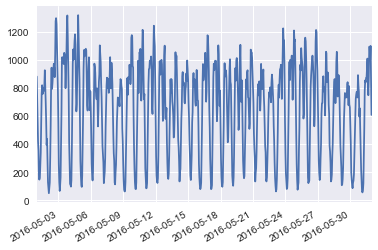

In [11]:
EW, SN = -(73+0.59/0.6+0.0009/0.6/0.6), 40+0.44/0.6+0.0052/0.6/0.6
a = regions[(regions.west<EW) & (regions.east>EW) & (regions.south<SN) & (regions.north>SN)].region.item()
dhr2.iloc[:,a-1].plot()

Наблюдается дневная и недельная сезонность.

**6. Находим число пар час-ячейка с нулевым количеством поездок.**

In [12]:
dhr3=dhr2.values.reshape(dhr2.shape[0]*dhr2.shape[1],)
len(dhr3[dhr3==0])

1718238

In [13]:
dhr2.to_csv('HourRegionDataFrame.csv')